# Homework 4: Classification

In 1912, the sinking of the Titanic caused shock and outrage around the world. Now, more than 100 years later, it still remains one of the deadliest maritime disasters in history. Of the 2224 passengers, 1502 were killed, meaning less than a third of those on board survived. 

Survival on the Titanic was not random; because the ship did not have enough lifeboats, women and children were more likely to survive. Wealthy people also had a higher likelihood of survival. Knowing this, we can use factors such a passenger's gender, age, and ticket price to predict whether or not they survived the tragedy. 

For this homework, I will use data from the Titanic competition on Kaggle (https://www.kaggle.com/c/titanic) to do exactly that. First, I'll explore and clean the available features, and then I'll use logistic regression, K-Nearest Neighbors, and Random Forest models to predict survival for a sub-group of Titanic passengers.

## Part 1: Cleaning and Visualizing the Data

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn import preprocessing

%matplotlib inline

In [2]:
#Read in the data
train = pd.read_csv("/Users/alidoxey/Downloads/train (1).csv")
test = pd.read_csv("/Users/alidoxey/Downloads/test (1).csv")

In [3]:
#Separate out passenger IDs to use in submission file
test_id = test.PassengerId

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The first two columns show a passenger's ID number (I already separated this out for the test data, so I'll just drop it in the training data) and the outcome variable, "Survived", which takes on a value of 1 if someone survived and 0 if not.

It looks like we have 10 features: 
 - Pclass: a passenger's ticket class. A pclass of 1 indicates that passenger was traveling first class. This should be useful in modeling
 - Name: this variable may be useful since titles such as "Dr." indicate whether a person is wealthy, but we already have information on ticket class and fare, so I don't think this would provide any additional predictive power
 - Sex: this should be useful, so I'll use one-hot encoding to make it a binary variable
 - Age: also useful and is already numeric
 - SibSp: indicates how many siblings or spouses a passenger traveled with
 - Parch: the same as SibSp, but for parents and children
 - Ticket: looks quasi-random. I'm not sure I'll get anything useful out of this
 - Fare: should be useful in determining a person's class
 - Cabin: cabin number. It looks like it has a lot of missing values, so it may have to be dropped
 - Embarked: port of embarkation. C = Cherbourg, Q = Queenstown, S = Southampton. I'll use one-hot encoding on this variable as well

Before I go any further, I'll check to make sure the training and test sets have the same number of features (recognizing that "test" should have one less column than "train" because it includes the outcome variable).

In [5]:
train.shape

(891, 12)

In [6]:
test.shape

(418, 11)

Looks good! So we have 891 observations in train and 418 in test. Now I'll move on to exploring the training set. 

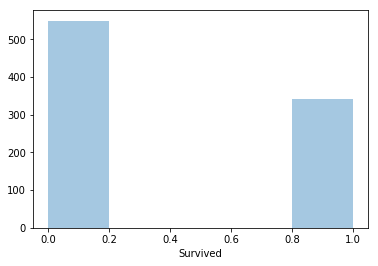

In [7]:
sns.distplot(train.Survived, kde = False)

This histogram shows that the survival rate for this sample of Titanic passengers is fairly representative: only about a third of the people in our sample survived.

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


These variables are clearly on different scales (Pclass varies from 1 to 3, while Fare varies from 0 to 512), so I'll try normalizing them after taking care of missing values. 

### Dealing with missing data

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


It looks like the Age, Cabin, and Embarked columns have missing values. I don't have a good way of using other features to predict a person's age, so I'll just impute it using its mean.

In [10]:
#impute age (this is the only numeric variable with missing values)
train = train.fillna(train.mean())
test = test.fillna(train.mean())

Next, I'll drop Cabin because it has less than 25% non-missing values, so we don't have enough information to make accurate imputations. 

In [11]:
train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)

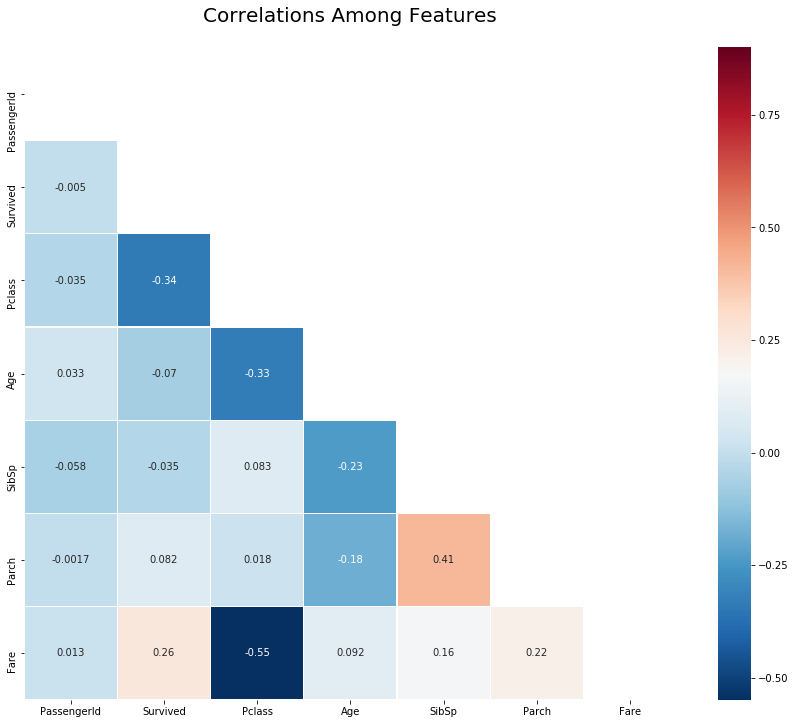

In [12]:
#Heatmap code from https://www.kaggle.com/masumrumi/a-statistical-analysis-of-titanic-with-ml-models

## heatmeap to see the correlation between features. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (15,12))
sns.heatmap(train.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20);

I'm not sure why the ticket variable was not included here, but it shouldn't be highly correlated with our outcome, so I'm going to drop it.

In [13]:
train.drop(['PassengerId', 'Ticket'], axis = 1, inplace = True)
test.drop(['PassengerId', 'Ticket'], axis = 1, inplace = True)

In [14]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


Last, I'll impute "Embarked". It's only missing in two observations, so I should be fine to impute the mode.

In [15]:
#impute "embarked"
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Embarked'] = test['Embarked'].fillna(train['Embarked'].mode()[0])

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


Great! No more missing data.

### Dealing with non-numeric data

As I said before, "Name" doesn't look useful for our analysis, and since each one should be unique, we can't create a dummy for each person on board.

In [17]:
# drop name
train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

Finally, I'll get dummies for gender and port of embarkation.

In [18]:
# one-hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [19]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(4), uint8(5)
memory usage: 46.2 KB


### Separating out the "Survived" column

In [21]:
labels = train.Survived
train.drop('Survived', axis = 1, inplace = True)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Pclass        891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.2 KB


### Scaling the data

In [24]:
from sklearn.preprocessing import StandardScaler

In [26]:
sc = StandardScaler()
train = sc.fit_transform(train)
test = sc.transform(test)
print(np.mean(train, 0))
print("\n")
print(np.std(train, 0))
print("-------")
print(np.mean(test, 0))
print("\n")
print(np.std(test, 0))

[ -8.77213254e-17   2.23290646e-16   4.38606627e-17   5.38289951e-17
   3.98733297e-18   3.98733297e-17  -1.15632656e-16  -1.99366649e-17
   0.00000000e+00  -8.37339924e-17]


[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
-------
[-0.05156969  0.03505159 -0.06863058  0.01334498  0.06875576  0.02349348
 -0.02349348  0.14180391  0.08409087 -0.1771445 ]


[ 1.00625661  0.97128251  0.81269066  1.21679298  1.12299036  1.00695788
  1.00695788  1.09804783  1.11376674  1.07106262]


## Part 2: Modeling

In [27]:
#Split training data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(train, labels, test_size=0.20, random_state=42)

### Logistic Regression

I started with the simplest model possible, not scaling the data or using cross-validation. I didn't expect this model to perform very well, but it was an easy place to start (and make sure I could format a submission properly) before I moved on to more complex models.

In [28]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [29]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_train_LR = logreg.predict(X_train)
y_pred_validation_LR = logreg.predict(X_validation)

In [30]:
y_pred_test_LR = logreg.predict(test)

all_predictions = []
all_predictions.append(y_pred_test_LR)

In [31]:
log_reg_train_mse = mean_squared_error(y_train, y_pred_train_LR)
log_reg_validation_mse = mean_squared_error(y_validation, y_pred_validation_LR)
print("Train MSE: {}".format(log_reg_train_mse))
print("Validation MSE: {}".format(log_reg_validation_mse))

Train MSE: 0.19803370786516855
Validation MSE: 0.18994413407821228


In [32]:
from sklearn.model_selection import RandomizedSearchCV

This did pretty well, but the validation MSE shows it may have overfit a bit. I'll try K-Nearest Neighbors next.

### K-Nearest Neighbors

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [34]:
#Code from K-Nearest Neighbors Lecture
clf = KNeighborsClassifier()
knn_rand_search = RandomizedSearchCV(clf, {"n_neighbors": [1, 3, 5, 7, 9, 11, 13], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, cv = 5, scoring='f1')
knn_rand_search.fit(train, labels)
print("Best Parameters: {}".format(knn_rand_search.best_params_))
y_pred_train_knn = knn_rand_search.predict(train)
print("Best F1: {}".format(knn_rand_search.best_score_))

Best Parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 9}
Best F1: 0.7366382810102002


In [35]:
y_pred_test_knn = knn_rand_search.predict(test)
all_predictions.append(y_pred_test_knn)

### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [37]:
Counter(y_train)

Counter({0: 444, 1: 268})

In [38]:
#Code from Random Forest Lecture
n_estimators = [1000, 2500, 5000]
max_depth = [1, 3, 5, 10]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            rf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            rf.fit(X_train, y_train)
            f1 = f1_score(y_train, np.argmax(rf.oob_decision_function_ , 1))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 1 balanced
1000 1 None
1000 3 balanced
1000 3 None
1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
2500 1 balanced
2500 1 None
2500 3 balanced
2500 3 None
2500 5 balanced
2500 5 None
2500 10 balanced
2500 10 None
5000 1 balanced
5000 1 None
5000 3 balanced
5000 3 None
5000 5 balanced
5000 5 None
5000 10 balanced
5000 10 None


In [39]:
print("Best params: {}".format(best_params))
print("Best OOB F1: {}".format(best_f1))

Best params: (1000, 5, None)
Best OOB F1: 0.756198347107438


In [40]:
rf = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])
rf.fit(X_train, y_train)
y_pred_train_rf_1 = rf.predict(X_train)
print("Train Classification Report:")
print(classification_report(y_train, y_pred_train_rf_1))

y_pred_validation_rf_1 = rf.predict(X_validation)
print("Validation Classification Report:")
print(classification_report(y_validation, y_pred_validation_rf_1))

Train Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.95      0.90       444
          1       0.90      0.71      0.79       268

avg / total       0.86      0.86      0.86       712

Validation Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.88      0.84       105
          1       0.80      0.70      0.75        74

avg / total       0.80      0.80      0.80       179



In [41]:
y_pred_test_rf_1 = rf.predict(test)
all_predictions.append(y_pred_test_rf_1)

Using traditional cross-validation

In [42]:
rf = RandomForestClassifier()
rf_rand_search = RandomizedSearchCV(rf, {"n_estimators": [1000, 2500, 5000], "class_weight": ['balanced', None],
                                      "max_depth": [1,3,5,7,9,11]}, cv = 5, scoring='f1')
rf_rand_search.fit(train, labels)
print("Best Parameters: {}".format(rf_rand_search.best_params_))
#y_pred_train_rf = rf_rand_search.predict(train)
print("Best F1: {}".format(rf_rand_search.best_score_))

Best Parameters: {'n_estimators': 2500, 'max_depth': 11, 'class_weight': None}
Best F1: 0.766208280123218


### Kaggle Submission

Save the best model's predictions to a new variable.

In [44]:
Y_pred = y_pred_test_rf_1

In [45]:
submission = pd.DataFrame({
        "PassengerId": test_id,
        "Survived": Y_pred
    })

In [46]:
submission.to_csv('titanic6.csv', index=False)

In [47]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


First submission: just logistic regression, no scaling or cross-validation. Rank: 8644

Second submission: accidentally the same as first

Third submission: logistic regression with scaling but no cross-validation. Rank: 7945 Accuracy: 0.761

Fourth submission: K-Nearest Neighbors with scaling and cross-validation. Rank: did not improve. Accuracy: 0.756

Fifth submission: Random Forest with scaling but no cross-validation. Rank: 1580 Accuracy: 0.799